# Project

In [1]:
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy import sparse
import scipy.sparse.linalg
from pyunlocbox import functions, solvers

## Bechdel Test

## Question 1  (from solutions)

In [2]:
adjacency = pd.read_csv('../Different Adjacency/CoAppearance-gender/CoAppGenderAdjacency.csv')
adjacency.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
edges = pd.read_csv('../Different Adjacency/CoAppearance-gender/CoAppGenderEdges.csv')
edges.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
features = pd.read_csv('../Different Adjacency/CoAppearance-gender/CoAppGenderFeatures.csv')
features.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
#adjacency = pd.read_csv('data/adjacency.csv')
n_nodes = len(adjacency)
n_nodes
#Dropping useless column from adjacency dataframe
#adjacency.drop('Unnamed: 0', axis = 1, inplace = True)
#adjacency = adjacency.values
#np.set_printoptions(suppress = True)
#n_nodes = len(adjacency)

3500

In [6]:
#labels = pd.read_csv('data/features.csv') #--> NO NEED CAUSE WE HAVE IT AT THE TOP
labels = features.reset_index()
id_to_idx = dict(zip(labels['id'], labels.index))

In [7]:
#edges = pd.read_csv('data/edges.csv')
#edges.drop('Unnamed: 0', axis = 1, inplace = True)
edges = pd.DataFrame(edges)
edges.head()
#edges[0] = edges[0].map(id_to_idx)
#edges[1] = edges[1].map(id_to_idx)
edges['0'] = edges['0'].map(id_to_idx)
edges['1'] = edges['1'].map(id_to_idx)
edges.head()

,0,1
0,1525,2857
1,1099,2857
2,229,2857
3,2470,2857
4,3162,2857


In [8]:
n_edges = len(edges)

In [9]:
adjacency= pd.DataFrame(adjacency)

In [10]:
# Recomputing the Laplacian
D = np.diag(np.sum(adjacency, 1)) # Degree matrix
D_norm = np.diag(np.sum(adjacency, 1)**(-1/2)) 
laplacian_combinatorial =  D - adjacency
laplacian_normalized =  D_norm @ laplacian_combinatorial @ D_norm

laplacian = laplacian_normalized

Compute the Fourier basis vectors and the Laplacian eigenvalues

In [11]:
e, U = np.linalg.eigh(laplacian)

The Eigenvalues are already sorted in ascending order:

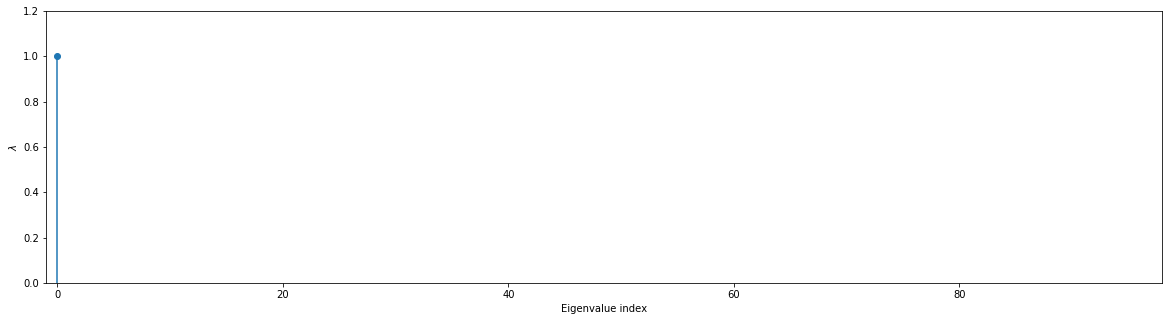

In [12]:
plt.figure(figsize=(20,5))

(markerline, stemlines, baseline)=plt.stem(np.arange(len(e)),e);
plt.setp(baseline, visible=False)
plt.ylim((0,1.2))
plt.xlim((-1,98))
plt.ylabel('$\lambda$');
plt.xlabel('Eigenvalue index');

Plot the first 3 and the last Fourier basis vectors as signals on your graph. Clearly indicate which plot belongs to which basis vector.

In [13]:
D_norm = np.diag(np.sum(adjacency, 1)**(-1/2)) 
network_emb = D_norm @ U[:,[1,3]]
emb_x = network_emb[:,0]
emb_y = network_emb[:,1]

We plot the first four and two last Fourier basis vectors instead to see some more variation:

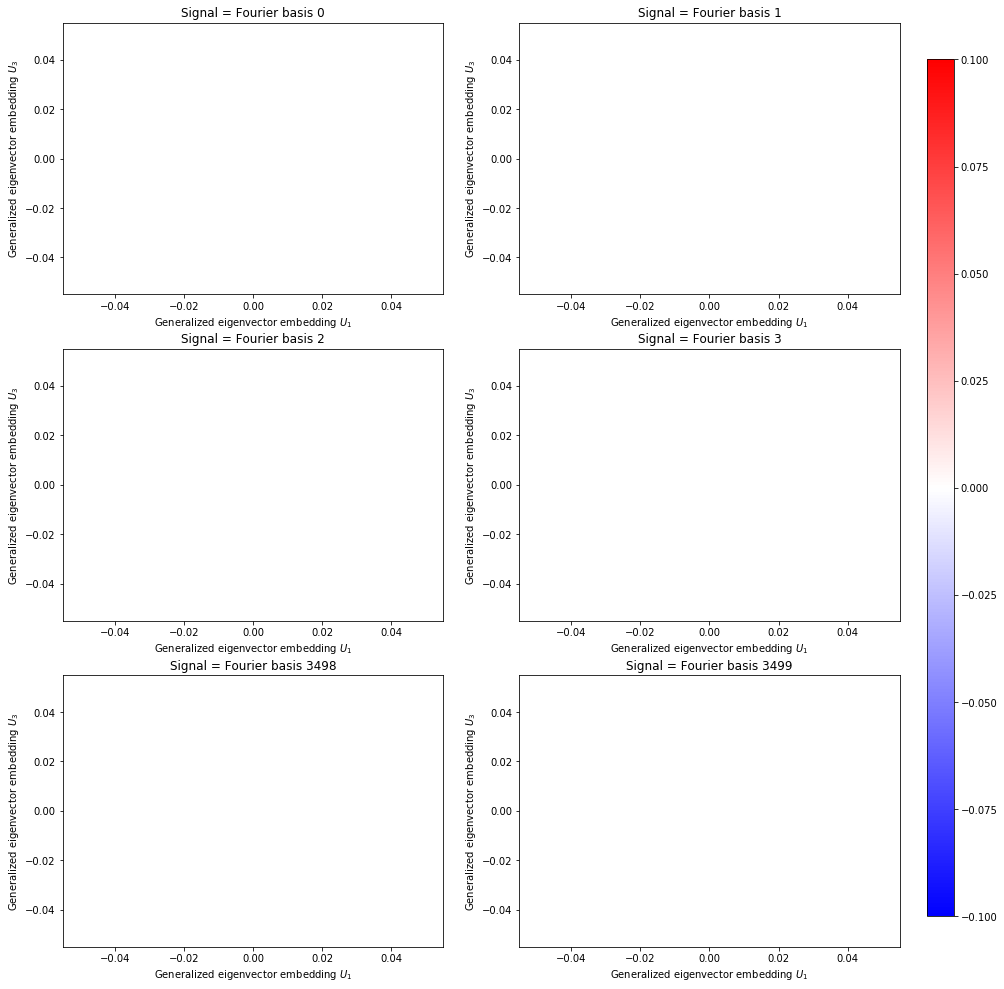

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(15,17))

fourier_bases = [0,1,2,3,len(adjacency)-2,len(adjacency)-1]

vmax = max(-U[:,fourier_bases].min(), U[:,fourier_bases].max())
vmin = -vmax

for ax_idx, fourier_basis in enumerate(fourier_bases):
    ax_x, ax_y = ax_idx//2, ax_idx%2
    im = ax[ax_x, ax_y].scatter(emb_x, emb_y, c=U[:,fourier_basis], cmap='bwr', s=70, 
                                edgecolors='black', vmin=vmin, vmax=vmax)
    ax[ax_x, ax_y].set_title('Signal = Fourier basis {}'.format(fourier_basis))
    ax[ax_x, ax_y].set_xlabel('Generalized eigenvector embedding $U_1$')
    ax[ax_x, ax_y].set_ylabel('Generalized eigenvector embedding $U_3$')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.925, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)

In addition to our own embedding using two chosen Eigenvectors, we would also like to display all graphs using NetworkX's Force-directed layout. This finds the party separation between the two main clusters and arranges them nicely (with one exception).

Also, in this representation we can plot all the edges without distracting too much from the nodes.

In [15]:
graph = nx.from_numpy_matrix(adjacency.as_matrix())
coords = nx.spring_layout(graph) # Force-directed layout.

/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


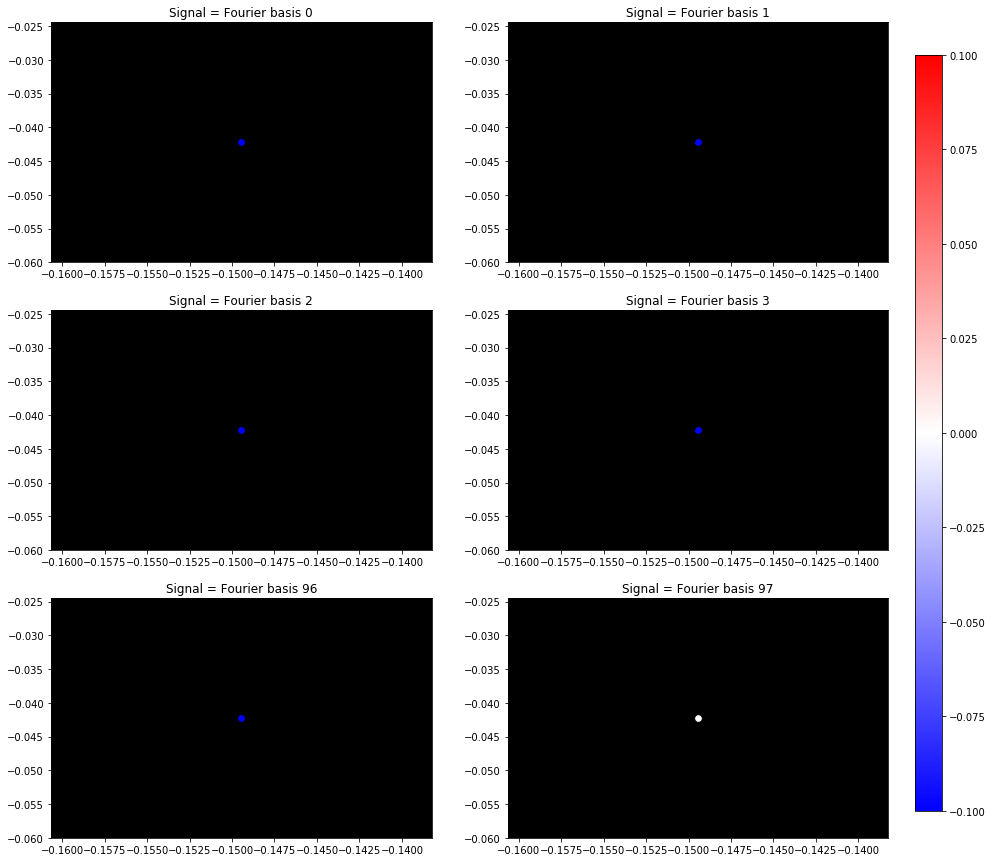

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))

fourier_bases = [0,1,2,3,96,97]

vmax = max(-U[:,fourier_bases].min(), U[:,fourier_bases].max())
vmin = -vmax

for ax_idx, fourier_basis in enumerate(fourier_bases):
    ax_x, ax_y = ax_idx//2, ax_idx%2
    im = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=U[:,fourier_basis], 
                                cmap='bwr', edgecolors='black', ax=ax[ax_x, ax_y], vmin=vmin, vmax=vmax)
    nx.draw_networkx_edges(graph, coords, alpha=0.2, ax=ax[ax_x, ax_y])
    ax[ax_x, ax_y].set_title('Signal = Fourier basis {}'.format(fourier_basis))
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.925, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)

## Question 2

What can you observe in terms of local variations when comparing the basis vectors corresponding to the smallest eigenvalues to those corresponding to the largest eigenvalue? How would this justify the interpretation of the eigenvalues as "graph frequencies"?

Your answer here:

For the signals corresponding to the smallest eigenvalues, we can observe them having very low frequencies over the network while still having very large weights. The basis vectors of larger eigenvalues contain mostly lower amplitudes and slightly higher frequencies. The one outlier node has a large influence over some of the Fourier bases, like basis 2.

## Question 3

Graph Fourier transform (GFT) and Inverse Graph Fourier transform (iGFT)

In [17]:
def GFT(x):
    return U.T @ x #The matmul function implements the semantics of the @ operator introduced in Python 3.5

def iGFT(x):
    return U @ x

## Question 4

Plot your feature/label vector as a signal on your graph

In [18]:
def coplot_network_signal(signal, title='Signal = ...'):
    '''
    Plots a signal on a graph using both a Laplacian embedding and the NetworkX force-directed layout.
    
    Args:
        signal: The signal of each node to plot on the graph
        title: Plot title
    '''
    fig, ax = plt.subplots(1, 2, figsize=(16,7))
        
    vmax = max(-np.nanmin(signal), np.nanmax(signal))
    vmin = -vmax

    im = ax[0].scatter(emb_x, emb_y, c=signal, cmap='bwr', s=70, edgecolors='black', 
                       vmin=vmin, vmax=vmax)
    ax[0].set_title('Laplacian Embedding')
    ax[0].set_xlabel('Generalized eigenvector embedding $U_1$')
    ax[0].set_ylabel('Generalized eigenvector embedding $U_3$')

    nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=signal, cmap='bwr', 
                           edgecolors='black', ax=ax[1], vmin=vmin, vmax=vmax)
    nx.draw_networkx_edges(graph, coords, alpha=0.2, ax=ax[1])
    ax[1].set_title('NetworkX Force-directed layout')

    fig.suptitle(title, fontsize=16)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.925, 0.15, 0.025, 0.7])
    fig.colorbar(im, cax=cbar_ax)

In [19]:
features.head()

,name,id,gender,genre_id_disc,vote_average,profit
0,Samuel L. Jackson,2231,2,80,6.5,160000000.0
1,Robert De Niro,380,2,80,6.5,50000000.0
2,Bruce Willis,62,2,80,6.0,90000000.0
3,Matt Damon,1892,2,18,6.5,100000000.0
4,Morgan Freeman,192,2,18,6.5,140000000.0


In [20]:
labels = features['profit']

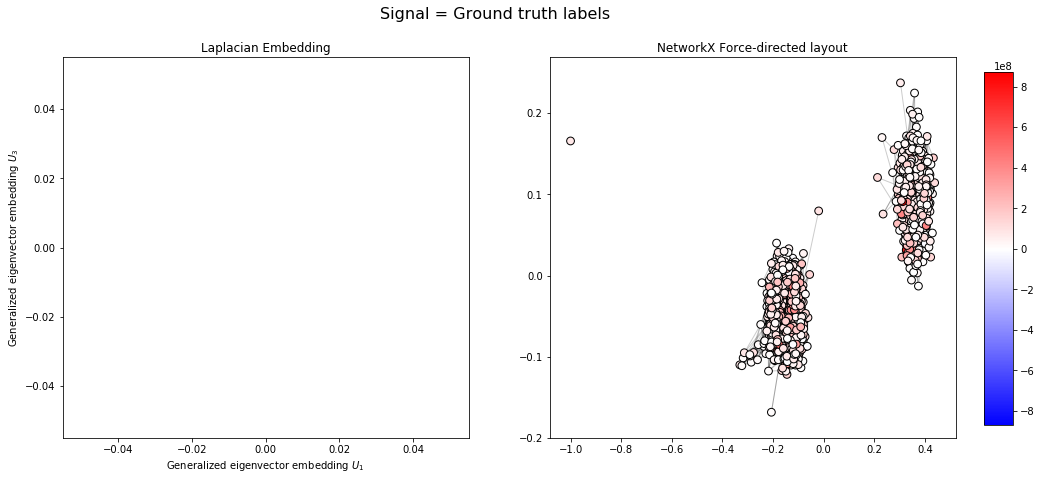

In [21]:
coplot_network_signal(labels, title='Signal = Ground truth labels')

Plot the absolute values of the GFT of your feature/label signal as a function of the graph eigenvalues. Make sure to add a marker indicating the position of each graph eigenvalue, and remember to properly name the axes.

We plot the signal with respect to the (normalized) Eigenvalue frequency as well as the respective index.

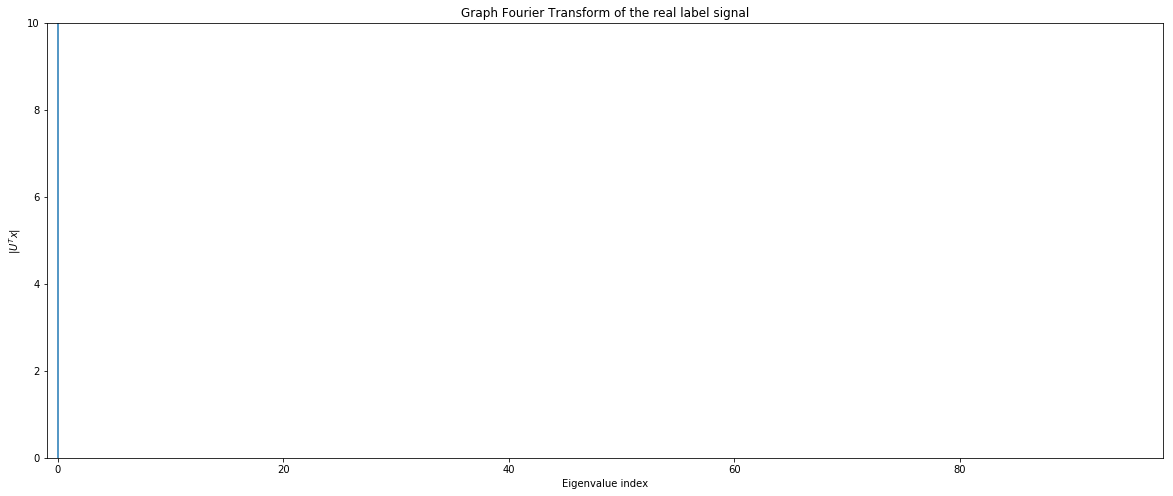

In [22]:
plt.figure(figsize=(20,8))

(markerline, stemlines, baseline)=plt.stem(np.arange(len(e)),abs(GFT(labels)));
plt.setp(baseline, visible=False)
plt.ylim((0,10))
plt.xlim((-1,98))
plt.title('Graph Fourier Transform of the real label signal')
plt.ylabel('$|U^T x|$');
plt.xlabel('Eigenvalue index');

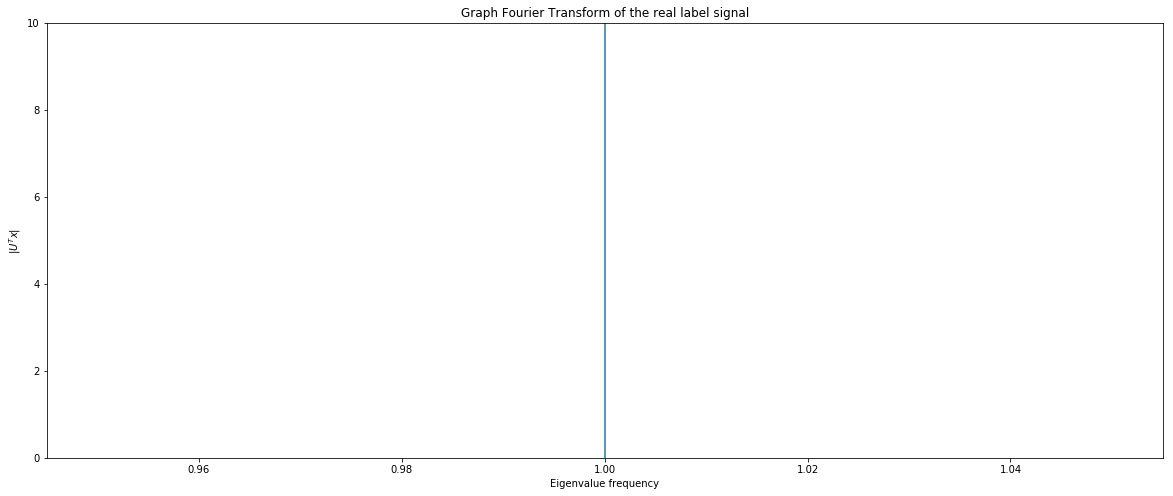

In [23]:
plt.figure(figsize=(20,8))

(markerline, stemlines, baseline)=plt.stem(e,abs(GFT(labels)));
plt.setp(baseline, visible=False)
plt.ylim((0,10))
plt.title('Graph Fourier Transform of the real label signal')
plt.ylabel('$|U^T x|$');
plt.xlabel('Eigenvalue frequency');

## Question 6

In [24]:
def heat_kernel(e, t):
    return np.exp(-t * e)

def inverse_kernel(e, t):
    return 1/(1 + t*e)

def rectangle_kernel(e, l_min, l_max):
    return ((e >= l_min) & (e <= l_max)).astype(float)

def graph_filter(x, kernel, **kwargs):
    return iGFT(kernel(e, **kwargs) * GFT(x))

## Question 7

Plot all three filter kernels in the spectral domain. Remember to properly name the axes and title the plots. Choose filter parameters that best approximate the behavior of the GFT of your feature/label signal (as seen in Question 4).

We plot the signal with respect to the (normalized) Eigenvalue frequency as well as the respective index.

/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


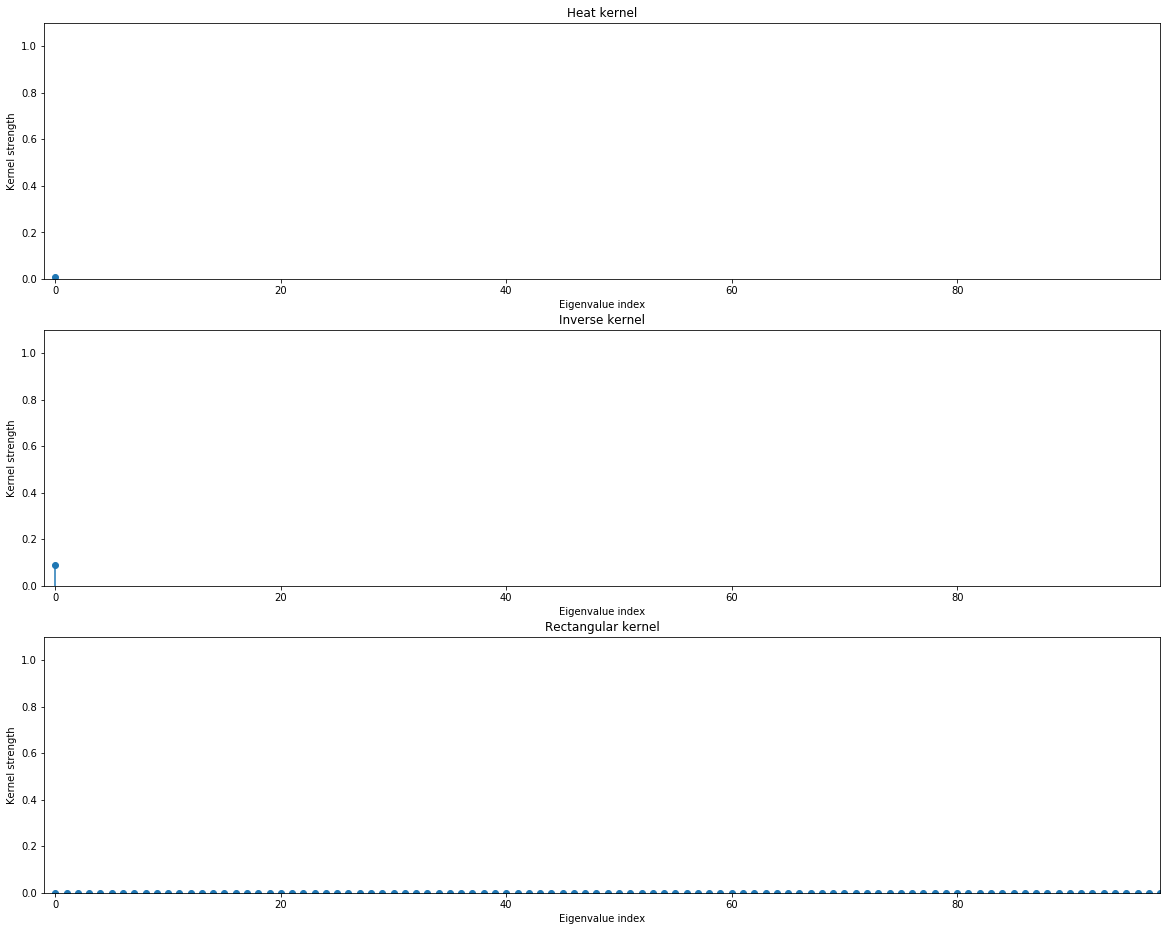

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(20,16))

kernels = {
    'Heat kernel': heat_kernel(e,5),
    'Inverse kernel': inverse_kernel(e,10),
    'Rectangular kernel': rectangle_kernel(e,0.1,0.8)
}

for idx, (kernel_name, kernel) in enumerate(kernels.items()):    
    (markerline, stemlines, baseline)=ax[idx].stem(np.arange(len(e)), kernel);
    plt.setp(baseline, visible=False)
    ax[idx].set_ylim((0,1.1))
    ax[idx].set_xlim((-1,98))
    ax[idx].set_title(kernel_name)
    ax[idx].set_ylabel('Kernel strength');
    ax[idx].set_xlabel('Eigenvalue index');

/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


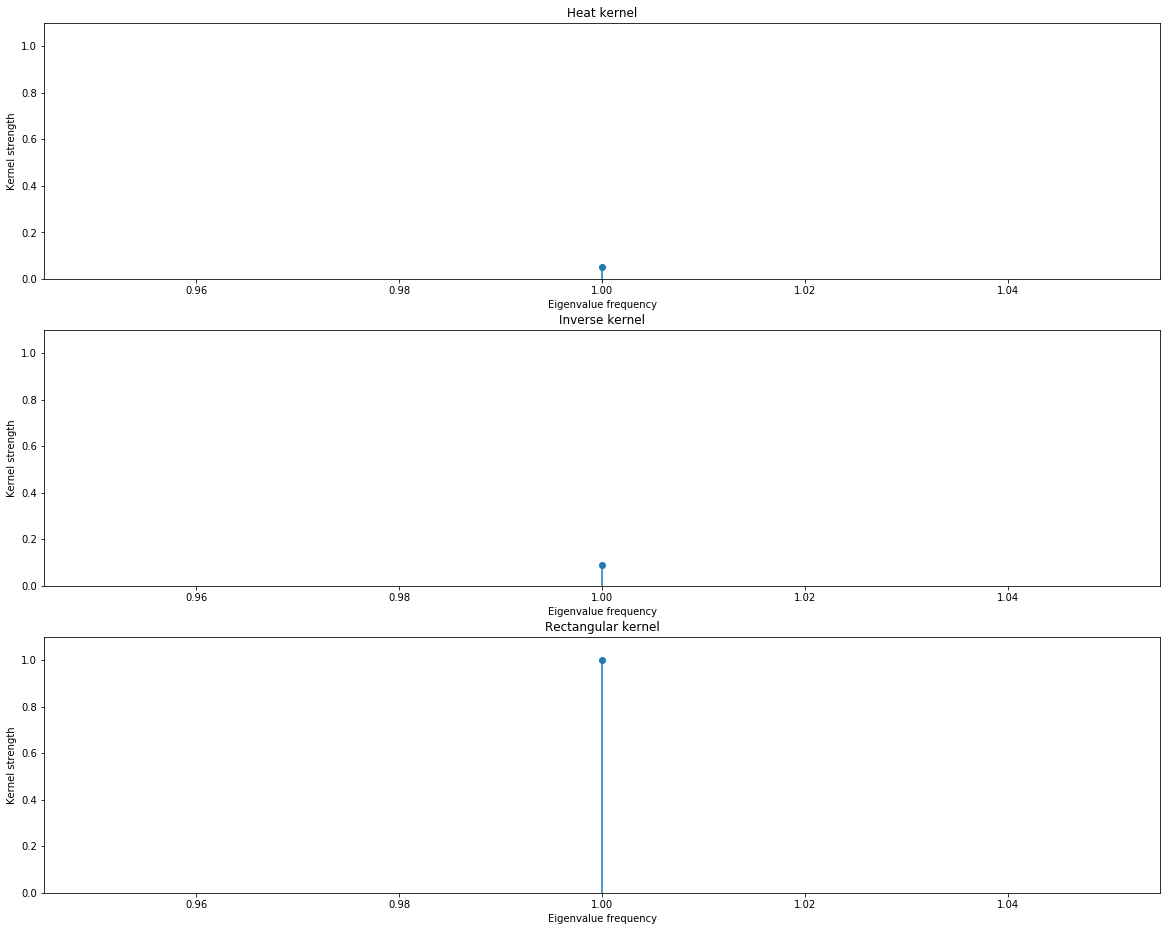

In [26]:
fig, ax = plt.subplots(3, 1, figsize=(20,16))

kernels = {
    'Heat kernel': heat_kernel(e,3),
    'Inverse kernel': inverse_kernel(e,10),
    'Rectangular kernel': rectangle_kernel(e,0.6,1.2)
}

for idx, (kernel_name, kernel) in enumerate(kernels.items()):    
    (markerline, stemlines, baseline)=ax[idx].stem(e, kernel);
    plt.setp(baseline, visible=False)
    ax[idx].set_ylim((0,1.1))
    ax[idx].set_title(kernel_name)
    ax[idx].set_ylabel('Kernel strength');
    ax[idx].set_xlabel('Eigenvalue frequency');

We chose the filter parameters such that the second peak gets preserved well, while larger frequencies are attenuated. With the rectangle kernel, we can very easily select the desired frequencies, while with the other two we have to find some equilibrium between the strength of the desired signal and the rest. In case of the heat kernel, we could nicely isolate the second peak while not having to worry about the first one, as it models a constant signal over the network. In the inverse kernel, we still have a tail with a lot of weight.

When filtering, we multiply this filter kernel by the Fourier spectrum of a signal, whereby the low frequencies are kept and the larger frequencies are discarded.

## Question 8

Consider two Dirac impulses arbitrarily placed on your graph. Plot their filtered versions by the three filter kernels implemented in Question 6.

In [27]:
def plot_filtered_diracs(dirac_dict, kernel_name, kernel, **kwargs):
    ''' 
    Plots the filtered signal of two randomly chosen dirac spikes on a graph. 
    Plots using both Laplacian embedding and NetworkX Force-directed layout.
    
    Args:
        dirac_dict: Dictionary specifying index and value of diracs. Eg: {30: 1, 60: -1}
        kernel_name: Used in the title to indicate used kernel type
        kernel: Kernel function to apply to diracs
        kwargs: Additional arguments for specific kernel
    '''
    diracs = np.zeros(n_nodes)
    dirac_idxs = list(dirac_dict.keys())
    for idx, dirac_value in dirac_dict.items():
        diracs[idx] = dirac_value

    filtered = graph_filter(diracs, kernel, **kwargs)

    vmax = max(-filtered.min(), filtered.max())
    vmin = -vmax

    # Plot using Laplacian embedding
    fig, ax = plt.subplots(1, 2, figsize=(16,7))
    # Plotting all nodes
    ax[0].scatter(emb_x, emb_y, c=filtered, cmap='PiYG', s=70, 
                  edgecolors='black', vmin=vmin, vmax=vmax)
    # Plotting the dirac locations
    im = ax[0].scatter(emb_x[dirac_idxs], emb_y[dirac_idxs], c=diracs[dirac_idxs], 
                       cmap='PiYG', s=300, edgecolors='black', vmin=vmin, vmax=vmax, marker='x')
    ax[0].set_title('Laplacian Embedding')
    ax[0].set_xlabel('Generalized eigenvector embedding $U_1$')
    ax[0].set_ylabel('Generalized eigenvector embedding $U_3$')

    # Plot using NetworkX
    nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=filtered, 
                           cmap='PiYG', edgecolors='black', ax=ax[1], vmin=vmin, vmax=vmax)
    nx.draw_networkx_edges(graph, coords, alpha=0.2, ax=ax[1])
    # Plotting the dirac locations
    d1_coords = coords[dirac_idxs[0]]
    d2_coords = coords[dirac_idxs[1]]
    im = ax[1].scatter(d1_coords[0], d1_coords[1], c=diracs[dirac_idxs[0]], 
                       cmap='PiYG', s=300, edgecolors='black', vmin=vmin, vmax=vmax, marker='x')
    im = ax[1].scatter(d2_coords[0], d2_coords[1], c=diracs[dirac_idxs[1]], 
                       cmap='PiYG', s=300, edgecolors='black', vmin=vmin, vmax=vmax, marker='x')
    ax[1].set_title('NetworkX Force-directed layout')

    fig.suptitle('Signal = Two diracs filtered using {}'.format(kernel_name), fontsize=16)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.925, 0.15, 0.025, 0.7])
    fig.colorbar(im, cax=cbar_ax)

In the following plots, as our graph consists of two main clusters, we will plot the following possible combinations of placing two dirac spikes:

8.1: Diracs of opposite signs in opposite clusters
8.2: Diracs of opposite signs in same cluster
8.3: Diracs of equal signs in opposite clusters
8.4: Diracs of equal signs in same cluster
For reproducibility reasons we will hereby not initialize the nodes randomly, but choose them arbitrarily ourself. We chose nodes 15, 30 and 60 for that purpose.

We plot the bellow graphs using a different color palette, as not to conflict the colours with any party associations in this exercise.

#### 8.1 Diracs of opposite signs in opposite clusters

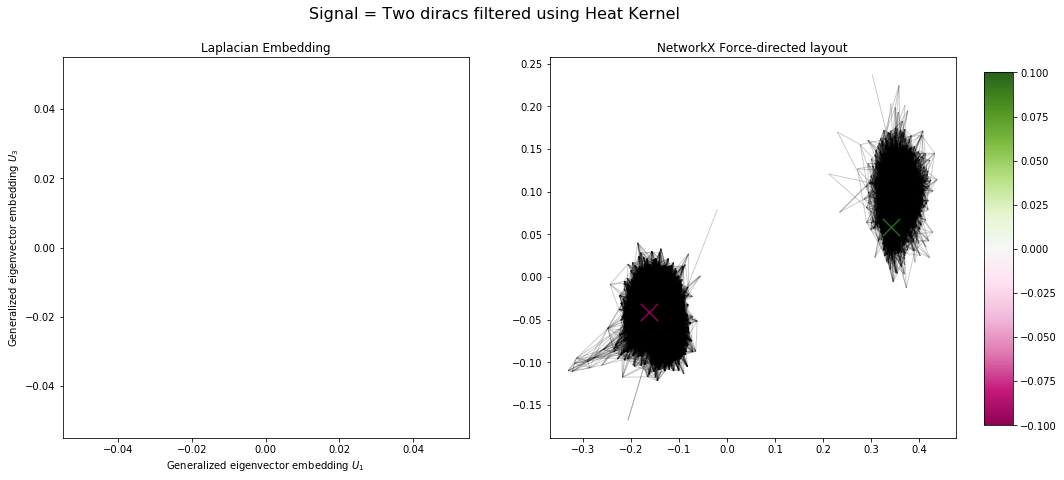

In [28]:
plot_filtered_diracs({30: -1, 60: 1}, 'Heat Kernel', heat_kernel, t=5)

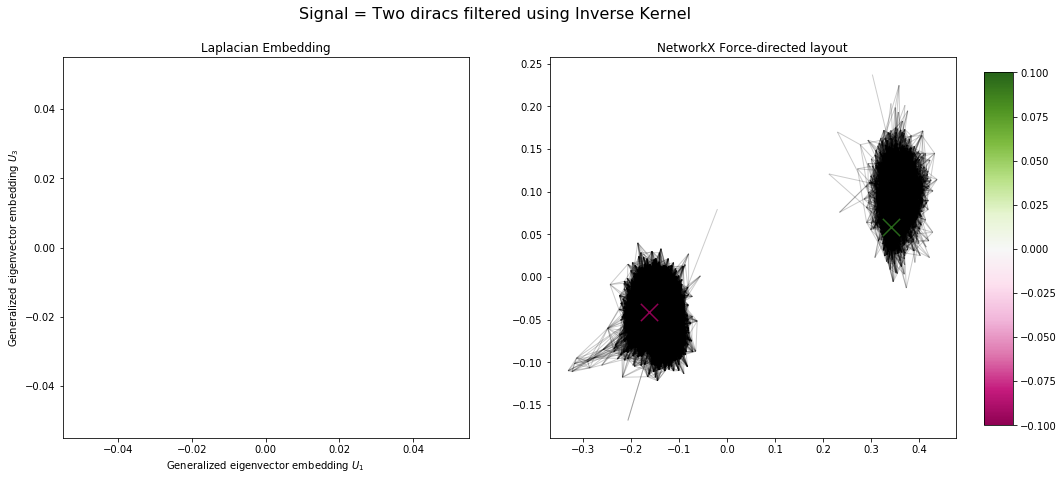

In [29]:
plot_filtered_diracs({30: -1, 60: 1}, 'Inverse Kernel', inverse_kernel, t=10)

/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


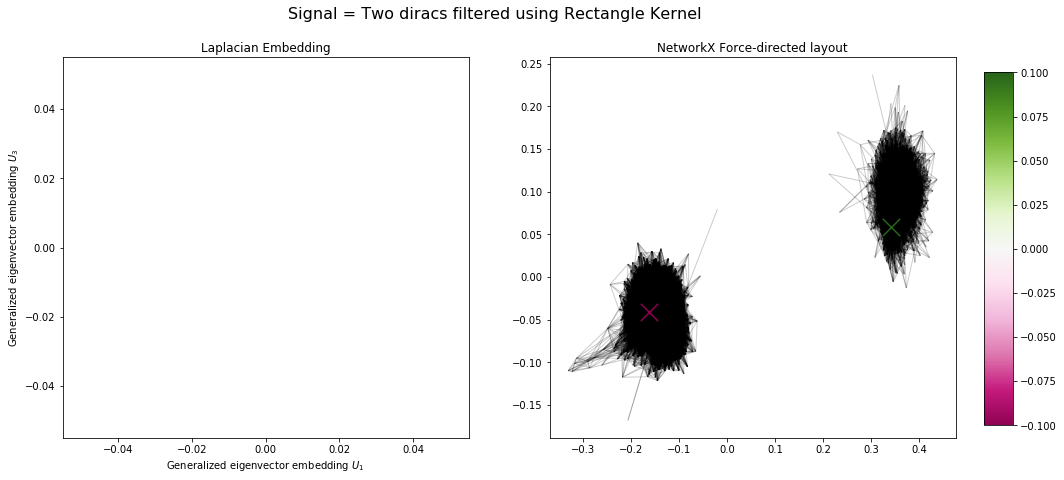

In [30]:
plot_filtered_diracs({30: -1, 60: 1}, 'Rectangle Kernel', rectangle_kernel, l_min=0.1, l_max=0.8)

#### 8.2 Diracs of opposite signs in same clusters

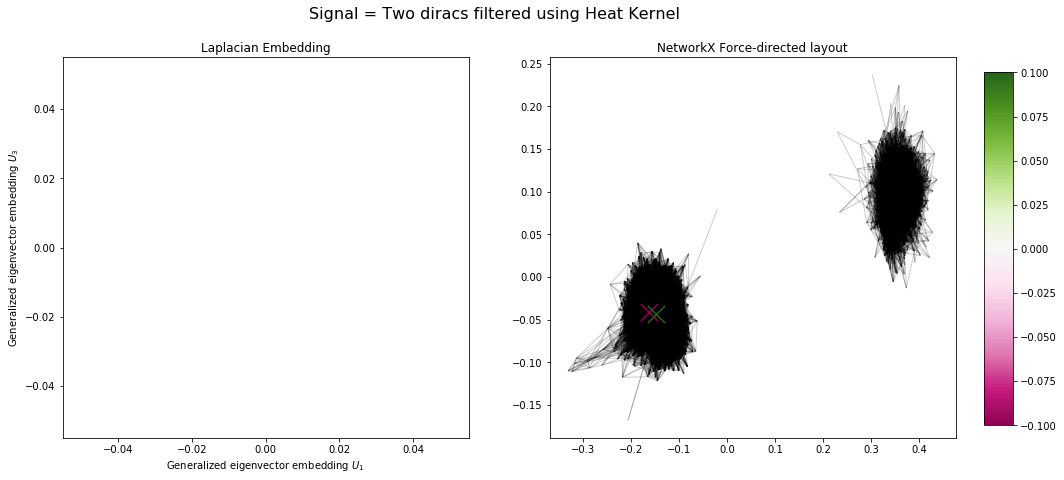

In [31]:
plot_filtered_diracs({30: -1, 15: 1}, 'Heat Kernel', heat_kernel, t=5)

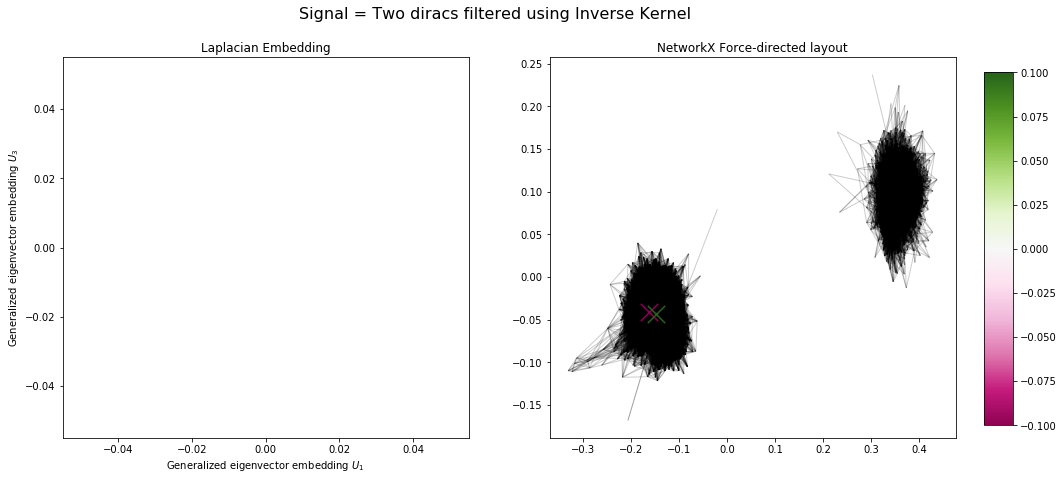

In [32]:
plot_filtered_diracs({30: -1, 15: 1}, 'Inverse Kernel', inverse_kernel, t=10)

/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


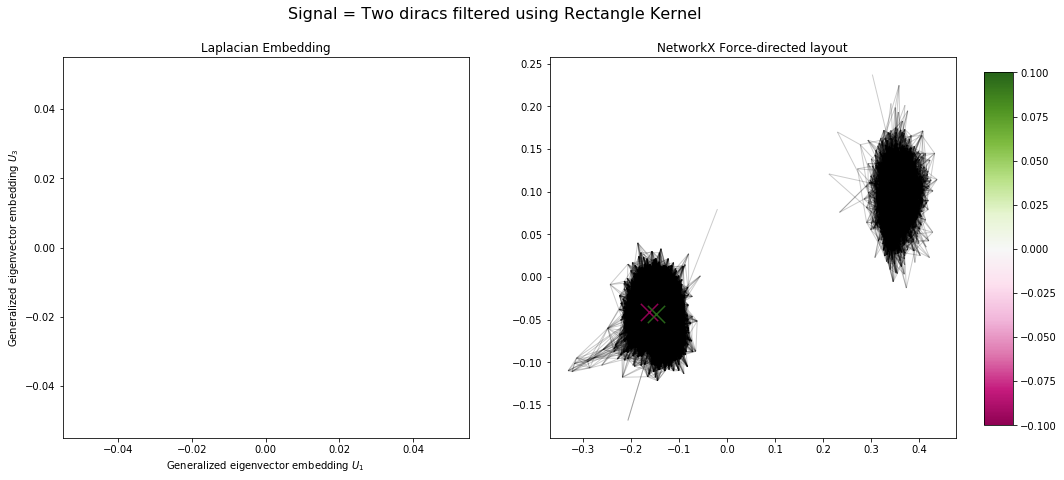

In [33]:
plot_filtered_diracs({30: -1, 15: 1}, 'Rectangle Kernel', rectangle_kernel, l_min=0.1, l_max=0.8)

#### 8.3 Diracs of equal signs in opposite clusters

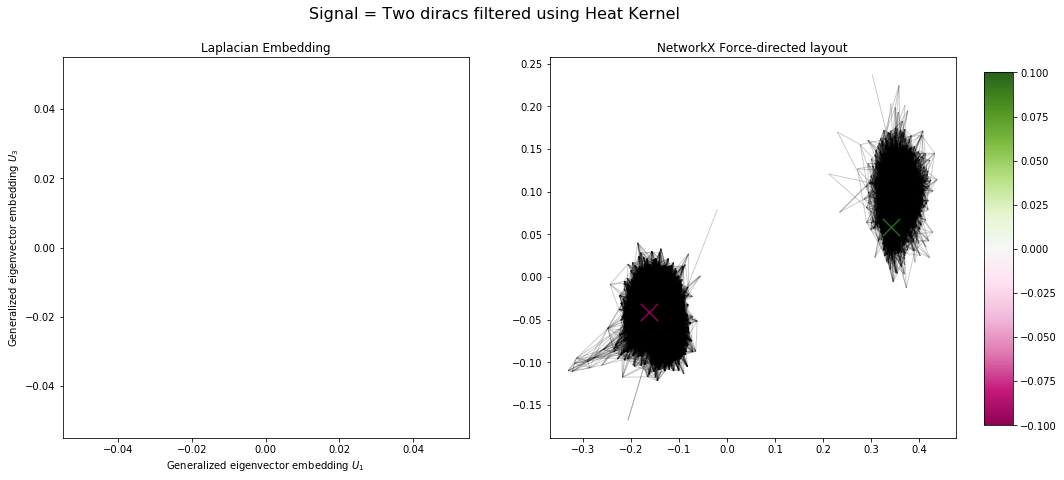

In [34]:
plot_filtered_diracs({30: 1, 60: 1}, 'Heat Kernel', heat_kernel, t=5)

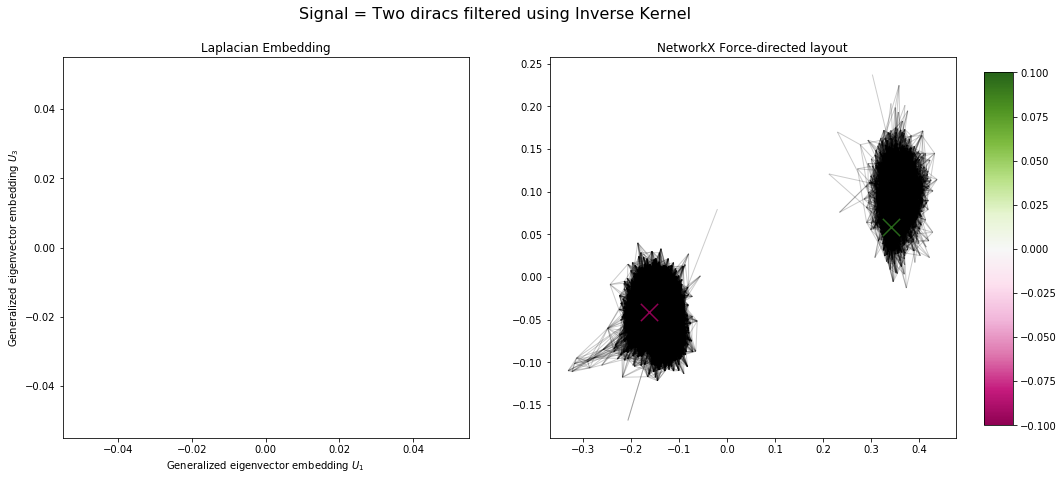

In [35]:
plot_filtered_diracs({30: 1, 60: 1}, 'Inverse Kernel', inverse_kernel, t=10)

/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


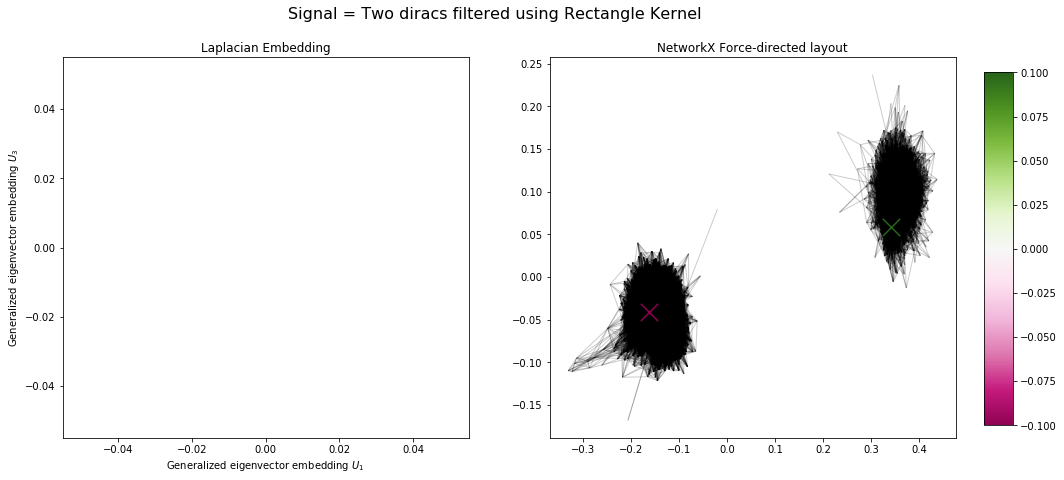

In [36]:
plot_filtered_diracs({30: 1, 60: 1}, 'Rectangle Kernel', rectangle_kernel, l_min=0.1, l_max=0.8)

#### 8.4 Diracs of equal signs in same cluster

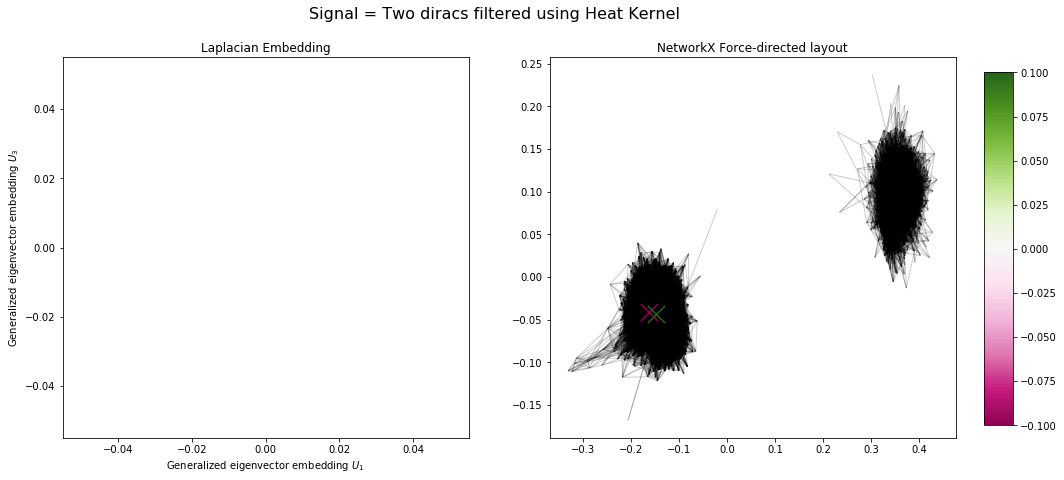

In [37]:
plot_filtered_diracs({30: 1, 15: 1}, 'Heat Kernel', heat_kernel, t=5)

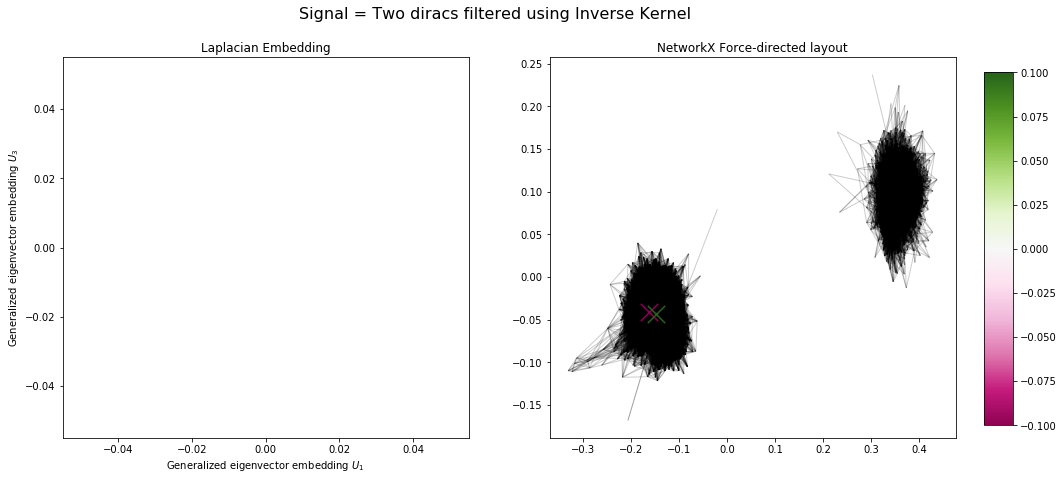

In [38]:
plot_filtered_diracs({30: 1, 15: 1}, 'Inverse Kernel', inverse_kernel, t=10)

/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


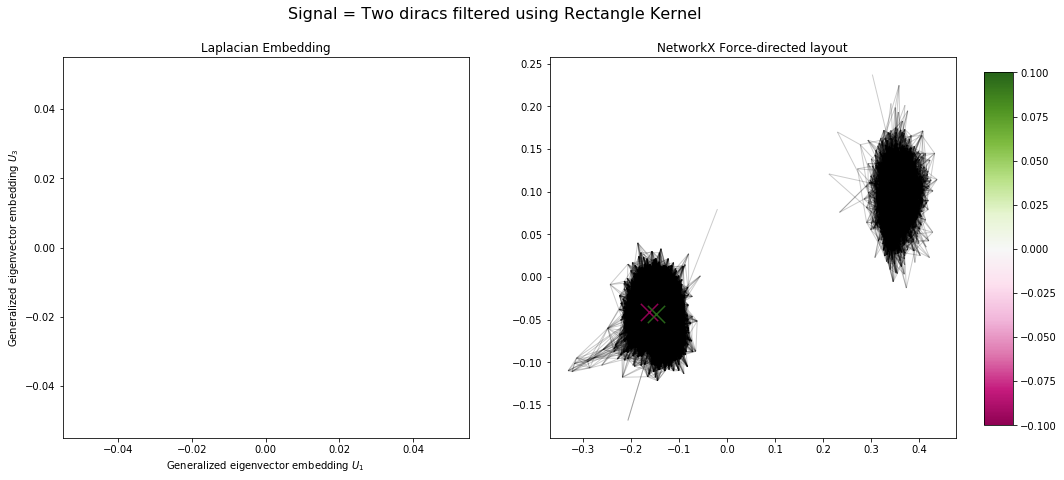

In [39]:
plot_filtered_diracs({30: 1, 15: 1}, 'Rectangle Kernel', rectangle_kernel, l_min=0.1, l_max=0.8)

## Question 9

In the cell below, set the noise variance $\sigma^2$ by making sure that the signal-to-noise ratio $SNR = \frac{\operatorname{Var}(\text{labels})}{\sigma^2}$ is about  $1.5$.

_Note:_ Actually, you might want to play with the noise variance here and set it to different values and see how the denoising filters behave.

In [40]:
noise_variance = labels.std()**2 / 1.5
noisy_measurements = labels + noise_variance * np.random.randn(n_nodes)

## Question 11

Now, denoise the noisy measurements by passing them through the filters that you implemented in Question 6. Choose the filter parameters based on the behavior of the GFT of your original label signal (this is the prior knowledge that you input to the problem).

Plot, on your graph, the original label signal, the noisy measurements, and the three denoised version obtained above. Report on each plot the value of the corresponding relative error 
$$
\text{rel-err} = \frac{\|\text{labels} - z \|_2}{\|\text{labels}\|_2},
$$
where $z$ is the plotted signal.

In [41]:
def rel_err(labels, z):
    ''' 
    Calculates the relative error between the true labels and an estimate z
    
    Args:
        labels: Ground truth signal
        z: Estimated signal
    '''
    return np.linalg.norm(labels - z, 2) / np.linalg.norm(labels, 2)

Relative Error: 0.00


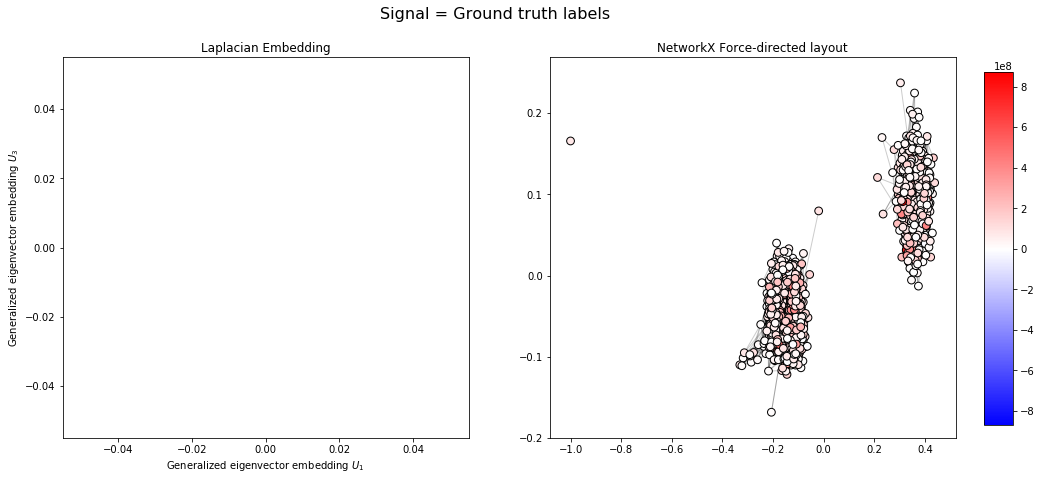

In [42]:
coplot_network_signal(labels, title='Signal = Ground truth labels')
print('Relative Error: {:.2f}'.format(rel_err(labels, labels)))

Relative Error: 45863074.96


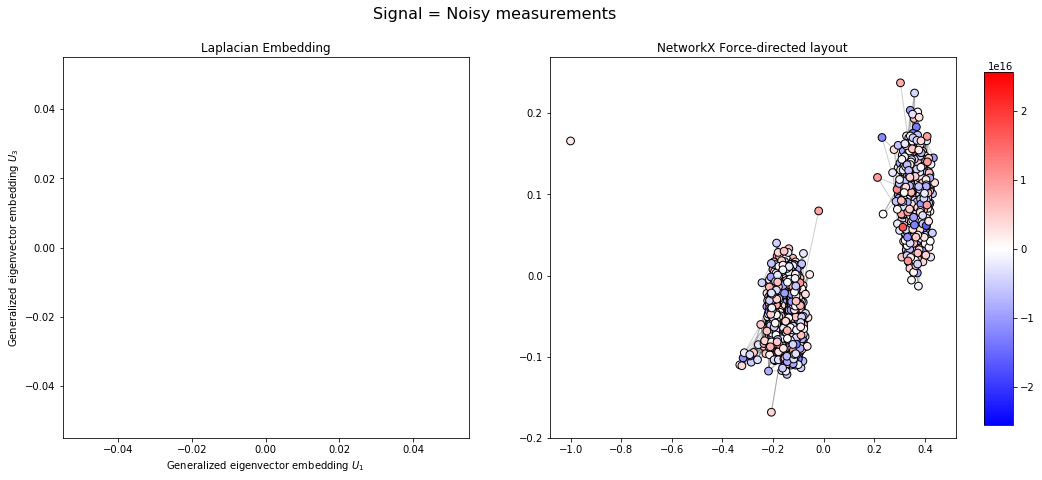

In [43]:
coplot_network_signal(noisy_measurements, title='Signal = Noisy measurements')
print('Relative Error: {:.2f}'.format(rel_err(labels, noisy_measurements)))

/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: All-NaN slice encountered
  # This is added back by InteractiveShellApp.init_path()


Relative Error: nan


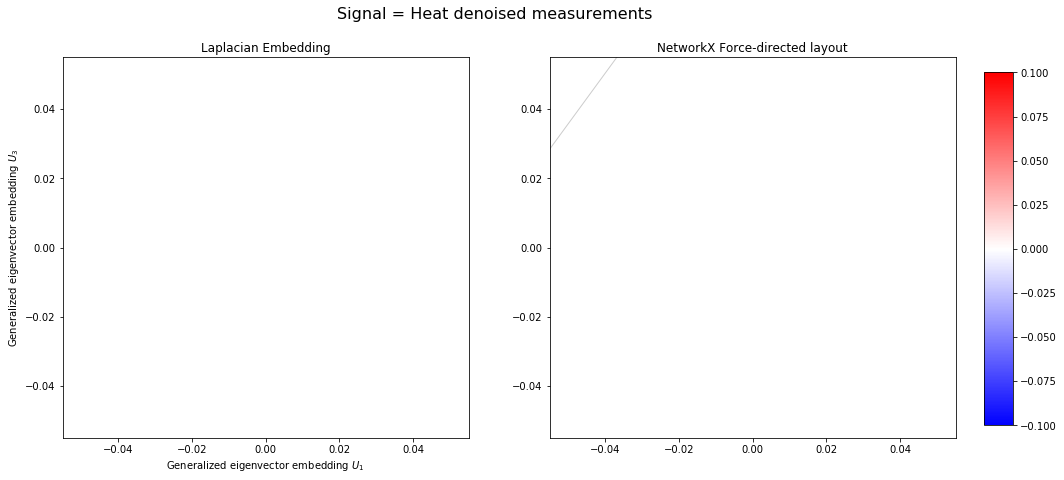

In [44]:
z_heat_denoised = graph_filter(noisy_measurements, heat_kernel, t=5)
coplot_network_signal(z_heat_denoised, title='Signal = Heat denoised measurements')
print('Relative Error: {:.2f}'.format(rel_err(labels, z_heat_denoised)))

/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: All-NaN slice encountered
  # This is added back by InteractiveShellApp.init_path()


Relative Error: nan


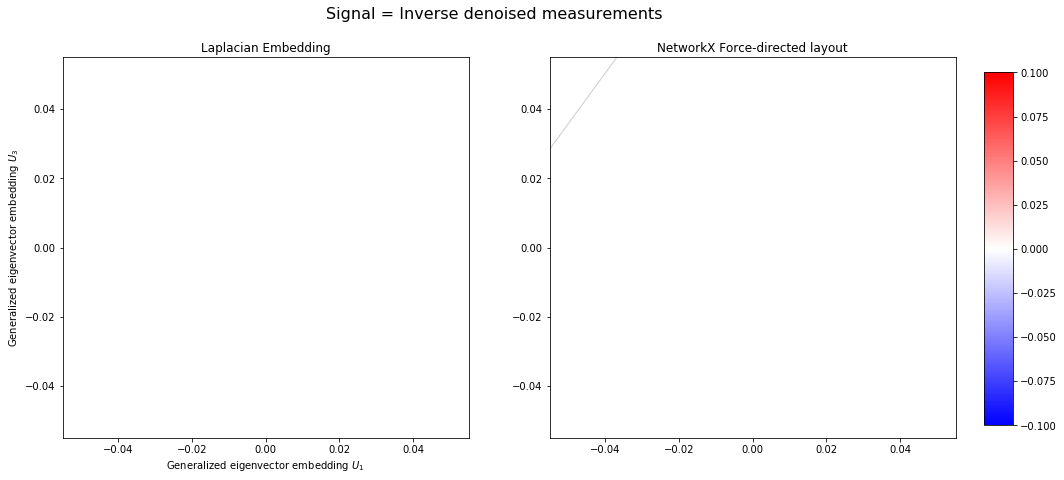

In [45]:
z_inv_denoised = graph_filter(noisy_measurements, inverse_kernel, t=5)
coplot_network_signal(z_inv_denoised, title='Signal = Inverse denoised measurements')
print('Relative Error: {:.2f}'.format(rel_err(labels, z_inv_denoised)))

/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: All-NaN slice encountered
  # This is added back by InteractiveShellApp.init_path()


Relative Error: nan


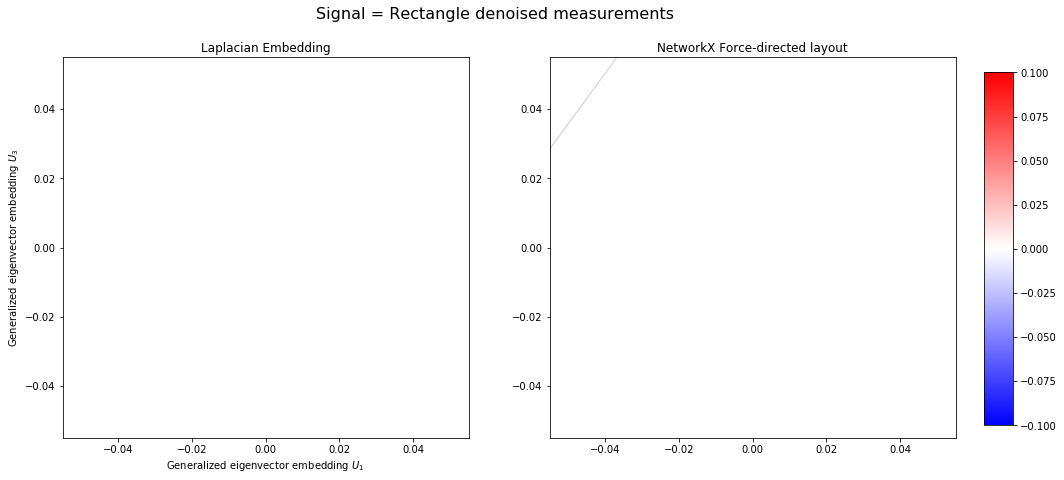

In [46]:
z_rect_denoised = graph_filter(noisy_measurements, rectangle_kernel, l_min=0.1, l_max=0.8)
coplot_network_signal(z_rect_denoised, title='Signal = Rectangle denoised measurements')
print('Relative Error: {:.2f}'.format(rel_err(labels, z_rect_denoised)))

Finally, overlay on the same plot the GFT of all five signals above.

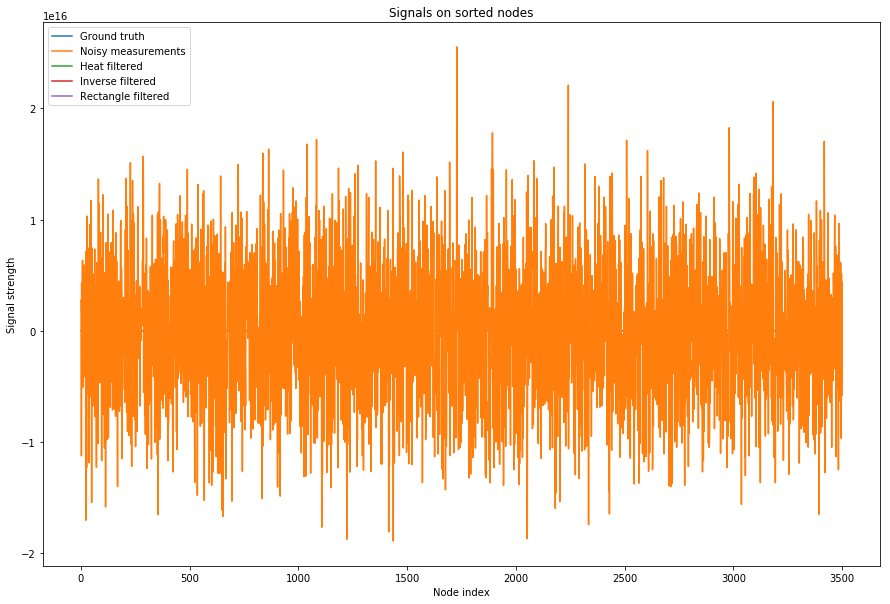

In [47]:
signals = {
    'Ground truth': labels,
    'Noisy measurements': noisy_measurements,
    'Heat filtered': z_heat_denoised,
    'Inverse filtered': z_inv_denoised,
    'Rectangle filtered': z_rect_denoised
}

plt.figure(figsize=(15,10))

for signal_name, signal in signals.items():
    plt.plot(signal, label=signal_name)
    
plt.xlabel('Node index')
plt.ylabel('Signal strength')
plt.title('Signals on sorted nodes')
plt.legend()